In [ ]:
from enum import IntEnum
import numpy as np
import bezier
import matplotlib.pyplot as plt

class LegPosition(IntEnum):
    FL = 0  # Front Left
    FR = 1  # Front Right
    BL = 2  # Back Left
    BR = 3  # Back Right

In [5]:
TRAJECTORY_CYCLE = 40
MAX_HEIGHT = 15.0
MIN_HEIGHT = 10.0
HALF_CYCLE = TRAJECTORY_CYCLE // 2
# bezier curve reference points
STEP_POINT_1 = [-1.0, -1.0, -MAX_HEIGHT]
STEP_POINT_2 = [-1.0, -1.0, -MIN_HEIGHT]
STEP_POINT_3 = [1.0, 1.0, -MIN_HEIGHT]
STEP_POINT_4 = [1.0, 1.0, -MAX_HEIGHT]

SLIDE_POINT_1 = [1.0, 1.0, -MAX_HEIGHT]
SLIDE_POINT_2 = [-1.0, -1.0, -MAX_HEIGHT]

STEP_NODES = np.asfortranarray([
    STEP_POINT_1,
    STEP_POINT_2,
    STEP_POINT_3,
    STEP_POINT_4,
]).T

SLIDE_NODES = np.asfortranarray([
    SLIDE_POINT_1,
    SLIDE_POINT_2,
]).T

def generate_motion():
    s_vals = np.linspace(0.0, 1.0, HALF_CYCLE)

    # Create step curve
    step_curve = bezier.Curve(STEP_NODES, degree=3)
    step = step_curve.evaluate_multi(s_vals)

    # Create slide curve
    slide_curve = bezier.Curve(SLIDE_NODES, degree=1)
    slide = slide_curve.evaluate_multi(s_vals)

    # Combine step and slide motions
    return np.concatenate((step, slide), axis=1)

In [6]:
def plot_motion_xz(motion: np.ndarray):
    """
    繪製一組 (3, 40) 動作數據在 X-Z 平面上的軌跡圖。
    motion: np.ndarray, shape = (3, 40), 代表每個點的 (x, z, y)，這裡只用 x 和 z
    """
    if motion.shape != (3, 40):
        raise ValueError("Input must be a numpy array of shape (3, 40)")

    x_coords = motion[0]
    z_coords = motion[2]  # 注意：這裡是 z 軸，不是 motion[1]（那是 y）

    plt.figure(figsize=(8, 6))
    plt.plot(x_coords, z_coords, marker='o')
    plt.title("Foot Trajectory in X-Z Plane")
    plt.xlabel("X Position")
    plt.ylabel("Z Position")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

In [7]:
def plot_motion_3d(motion: np.ndarray):
    """
    Plot the motion trajectory in 3D space.
    motion: np.ndarray, shape = (3, 40), representing x, y, z coordinates
    """
    if motion.shape != (3, 40):
        raise ValueError("Input must be a numpy array of shape (3, 40)")
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    x_coords = motion[0]
    y_coords = motion[1]
    z_coords = motion[2]
    
    ax.plot(x_coords, y_coords, z_coords, marker='o', linestyle='-', color='b')
    
    # Set labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    
    # Set equal scaling
    ax.set_box_aspect([np.ptp(x_coords), np.ptp(y_coords), np.ptp(z_coords)])
    
    # Add title
    ax.set_title('3D Foot Trajectory')
    
    # Add grid
    ax.grid(True)
    
    plt.show()

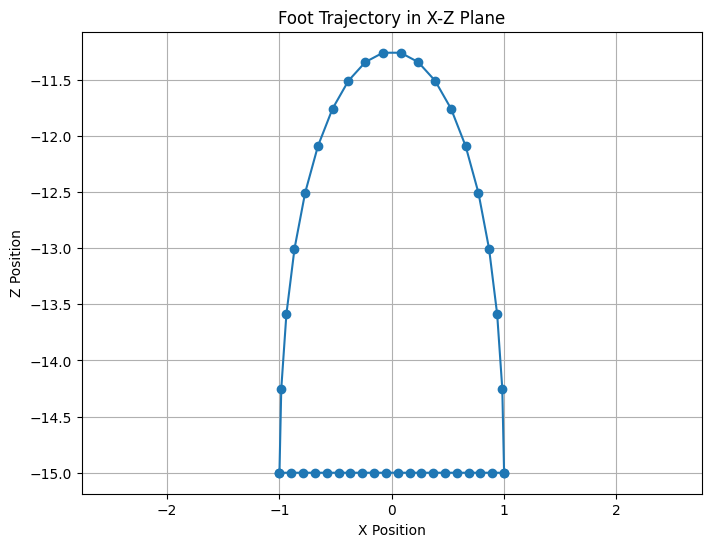

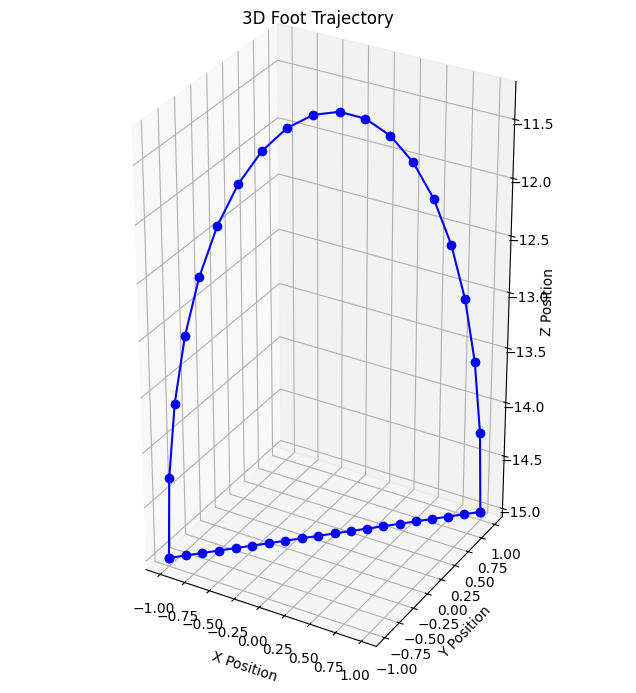

In [8]:
original_motion = generate_motion()

plot_motion_xz(original_motion)
plot_motion_3d(original_motion)


In [9]:
def adjust_for_turning(motion: np.ndarray, turning_factor: float, leg: LegPosition) -> np.ndarray:
    if turning_factor > 0:  # Turn Right
        if leg in (LegPosition.FL, LegPosition.BL):
            motion[0, :] *= (1 + turning_factor)
        else:
            motion[0, :] *= (1 - turning_factor)
    elif turning_factor < 0:  # Turn Left
        turning_factor = abs(turning_factor)
        if leg in (LegPosition.FL, LegPosition.BL):
            motion[0, :] *= (1 - turning_factor)
        else:
            motion[0, :] *= (1 + turning_factor)
    return motion

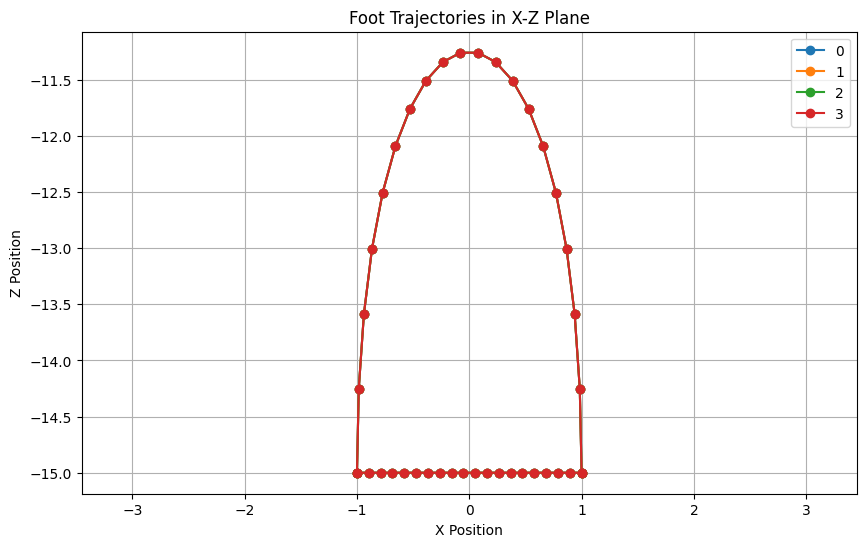

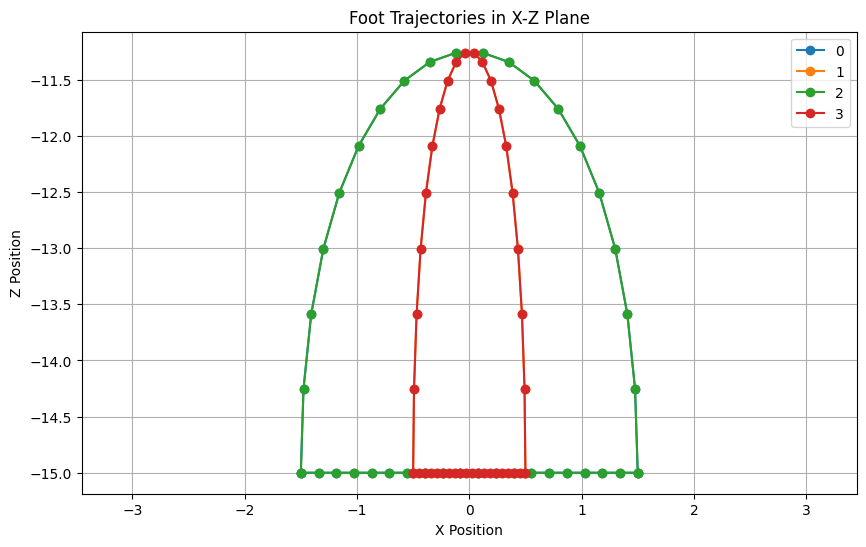

In [25]:
original_motions = {
    leg: generate_motion()
    for leg in LegPosition
}

adjusted_motions = {
    leg: original_motions[leg].copy()
    for leg in LegPosition
}

for leg in LegPosition:
    adjusted_motions[leg] = adjust_for_turning(adjusted_motions[leg], 0.5, leg)

plot_all_leg_motions(original_motions)
plot_all_leg_motions(adjusted_motions)

In [11]:
def plot_all_leg_motions(motions: dict):
    """
    繪製所有腿的 X-Z 平面軌跡。
    
    motions: dict[LegPosition, np.ndarray]，每個值都是 shape (3, 40)
    """
    plt.figure(figsize=(10, 6))

    for leg, motion in motions.items():
        if motion.shape != (3, 40):
            raise ValueError(f"Motion for leg {leg} is not shape (3, 40)")

        x_coords = motion[0]
        z_coords = motion[2]  # y 軸為高度，不畫
        plt.plot(x_coords, z_coords, marker='o', label=str(leg))

    plt.title("Foot Trajectories in X-Z Plane")
    plt.xlabel("X Position")
    plt.ylabel("Z Position")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()




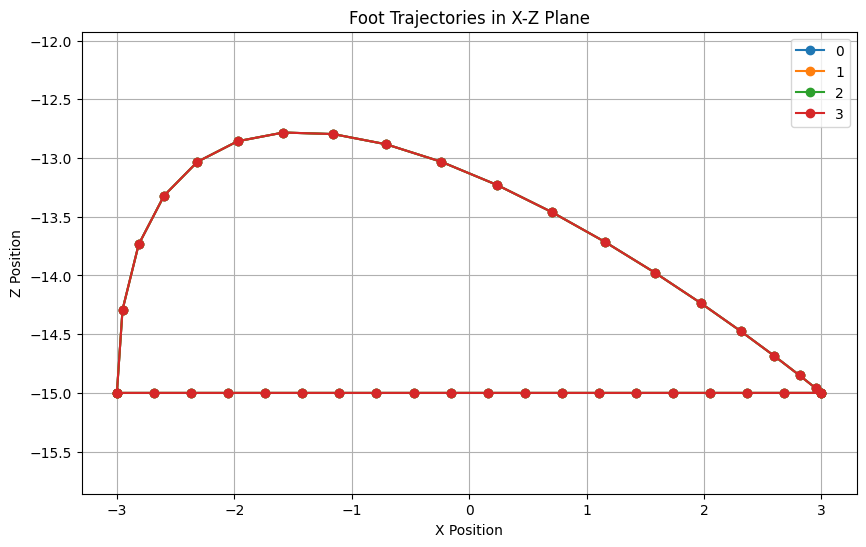

In [12]:
motions = {
    LegPosition.FL: np.array(
        [[ -3.        ,  -2.95188803,  -2.81455023,  -2.59848374,
         -2.31418574,  -1.97215338,  -1.5828838 ,  -1.15687418,
         -0.70462166,  -0.23662341,   0.23662341,   0.70462166,
          1.15687418,   1.5828838 ,   1.97215338,   2.31418574,
          2.59848374,   2.81455023,   2.95188803,   3.        ,
          3.        ,   2.68421053,   2.36842105,   2.05263158,
          1.73684211,   1.42105263,   1.10526316,   0.78947368,
          0.47368421,   0.15789474,  -0.15789474,  -0.47368421,
         -0.78947368,  -1.10526316,  -1.42105263,  -1.73684211,
         -2.05263158,  -2.36842105,  -2.68421053,  -3.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]
    ),
    LegPosition.FR: np.array(
        [[ -3.        ,  -2.95188803,  -2.81455023,  -2.59848374,
         -2.31418574,  -1.97215338,  -1.5828838 ,  -1.15687418,
         -0.70462166,  -0.23662341,   0.23662341,   0.70462166,
          1.15687418,   1.5828838 ,   1.97215338,   2.31418574,
          2.59848374,   2.81455023,   2.95188803,   3.        ,
          3.        ,   2.68421053,   2.36842105,   2.05263158,
          1.73684211,   1.42105263,   1.10526316,   0.78947368,
          0.47368421,   0.15789474,  -0.15789474,  -0.47368421,
         -0.78947368,  -1.10526316,  -1.42105263,  -1.73684211,
         -2.05263158,  -2.36842105,  -2.68421053,  -3.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]
    ),
    LegPosition.BL: np.array(
        [[ -3.        ,  -2.95188803,  -2.81455023,  -2.59848374,
         -2.31418574,  -1.97215338,  -1.5828838 ,  -1.15687418,
         -0.70462166,  -0.23662341,   0.23662341,   0.70462166,
          1.15687418,   1.5828838 ,   1.97215338,   2.31418574,
          2.59848374,   2.81455023,   2.95188803,   3.        ,
          3.        ,   2.68421053,   2.36842105,   2.05263158,
          1.73684211,   1.42105263,   1.10526316,   0.78947368,
          0.47368421,   0.15789474,  -0.15789474,  -0.47368421,
         -0.78947368,  -1.10526316,  -1.42105263,  -1.73684211,
         -2.05263158,  -2.36842105,  -2.68421053,  -3.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]
    ),
    LegPosition.BR: np.array(
        [[ -3.        ,  -2.95188803,  -2.81455023,  -2.59848374,
         -2.31418574,  -1.97215338,  -1.5828838 ,  -1.15687418,
         -0.70462166,  -0.23662341,   0.23662341,   0.70462166,
          1.15687418,   1.5828838 ,   1.97215338,   2.31418574,
          2.59848374,   2.81455023,   2.95188803,   3.        ,
          3.        ,   2.68421053,   2.36842105,   2.05263158,
          1.73684211,   1.42105263,   1.10526316,   0.78947368,
          0.47368421,   0.15789474,  -0.15789474,  -0.47368421,
         -0.78947368,  -1.10526316,  -1.42105263,  -1.73684211,
         -2.05263158,  -2.36842105,  -2.68421053,  -3.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]
    )
}

plot_all_leg_motions(motions)

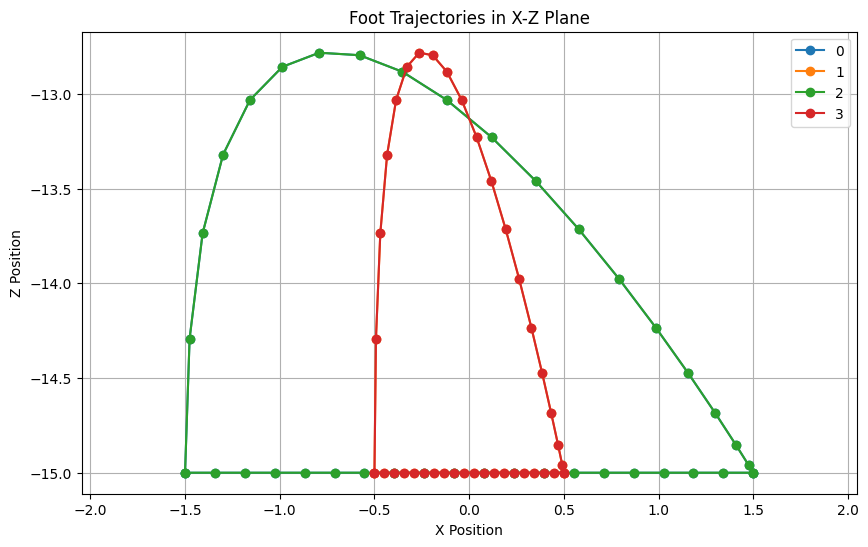

In [13]:
motions = {
    LegPosition.FL: np.array([[ -1.5       ,  -1.47594402,  -1.40727511,  -1.29924187,
         -1.15709287,  -0.98607669,  -0.7914419 ,  -0.57843709,
         -0.35231083,  -0.11831171,   0.11831171,   0.35231083,
          0.57843709,   0.7914419 ,   0.98607669,   1.15709287,
          1.29924187,   1.40727511,   1.47594402,   1.5       ,
          1.5       ,   1.34210526,   1.18421053,   1.02631579,
          0.86842105,   0.71052632,   0.55263158,   0.39473684,
          0.23684211,   0.07894737,  -0.07894737,  -0.23684211,
         -0.39473684,  -0.55263158,  -0.71052632,  -0.86842105,
         -1.02631579,  -1.18421053,  -1.34210526,  -1.5       ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]),
    LegPosition.FR: np.array([[ -0.5       ,  -0.49198134,  -0.4690917 ,  -0.43308062,
         -0.38569762,  -0.32869223,  -0.26381397,  -0.19281236,
         -0.11743694,  -0.03943724,   0.03943724,   0.11743694,
          0.19281236,   0.26381397,   0.32869223,   0.38569762,
          0.43308062,   0.4690917 ,   0.49198134,   0.5       ,
          0.5       ,   0.44736842,   0.39473684,   0.34210526,
          0.28947368,   0.23684211,   0.18421053,   0.13157895,
          0.07894737,   0.02631579,  -0.02631579,  -0.07894737,
         -0.13157895,  -0.18421053,  -0.23684211,  -0.28947368,
         -0.34210526,  -0.39473684,  -0.44736842,  -0.5       ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]),
    LegPosition.BL: np.array([[ -1.5       ,  -1.47594402,  -1.40727511,  -1.29924187,
         -1.15709287,  -0.98607669,  -0.7914419 ,  -0.57843709,
         -0.35231083,  -0.11831171,   0.11831171,   0.35231083,
          0.57843709,   0.7914419 ,   0.98607669,   1.15709287,
          1.29924187,   1.40727511,   1.47594402,   1.5       ,
          1.5       ,   1.34210526,   1.18421053,   1.02631579,
          0.86842105,   0.71052632,   0.55263158,   0.39473684,
          0.23684211,   0.07894737,  -0.07894737,  -0.23684211,
         -0.39473684,  -0.55263158,  -0.71052632,  -0.86842105,
         -1.02631579,  -1.18421053,  -1.34210526,  -1.5       ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]),
    LegPosition.BR: np.array(
        [[ -0.5       ,  -0.49198134,  -0.4690917 ,  -0.43308062,
         -0.38569762,  -0.32869223,  -0.26381397,  -0.19281236,
         -0.11743694,  -0.03943724,   0.03943724,   0.11743694,
          0.19281236,   0.26381397,   0.32869223,   0.38569762,
          0.43308062,   0.4690917 ,   0.49198134,   0.5       ,
          0.5       ,   0.44736842,   0.39473684,   0.34210526,
          0.28947368,   0.23684211,   0.18421053,   0.13157895,
          0.07894737,   0.02631579,  -0.02631579,  -0.07894737,
         -0.13157895,  -0.18421053,  -0.23684211,  -0.28947368,
         -0.34210526,  -0.39473684,  -0.44736842,  -0.5       ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [-15.        , -14.2914419 , -13.73596734, -13.32045488,
        -13.03178306, -12.85683044, -12.78247558, -12.79559703,
        -12.88307333, -13.03178306, -13.22860475, -13.46041697,
        -13.71409827, -13.97652719, -14.2345823 , -14.47514215,
        -14.68508529, -14.85129028, -14.96063566, -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ,
        -15.        , -15.        , -15.        , -15.        ]]
    )
}

plot_all_leg_motions(motions)